In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.gaussian_process as gp
from sklearn.neural_network import MLPRegressor
from scipy.interpolate import UnivariateSpline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy.signal import savgol_filter
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
def split_data(df, size):
    '''
    The spectra are split into a training set and 
    testing set with a ratio of the size_list. The predicted features are the coordination number, 
    number of Cu atoms, and number of Te atoms.
    '''
    
    X = df.drop(labels=['CN', 'Num Cu', 'Num Te'], axis=1)
    list = X.columns.tolist()

    X.columns = range(X.shape[1])
    X.columns = list
   
    y = df[['CN', 'Num Cu', 'Num Te']]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size, random_state=12)
    
    return X_train, X_test, y_train, y_test, X, y

def derivatives(X):
    '''
    Calculates and returns the first and second derivative of the spectra
    '''

    dmu1 = np.zeros([len(mu_df), len(mu_df.columns)-1])
    dmu2 = np.zeros([len(mu_df), len(mu_df.columns)-2])

    if len(mu_df.columns) == 1000:
        dx =0.1*dx

    for i in range(len(mu_df)):
        for j in range(len(mu_df.columns)-1):
            dmu1[i, j] = (mu_df.iloc[i, j+1] - mu_df.iloc[i, j]) / dx

    for i_ in range(len(mu_df)):
        for j_ in range(len(mu_df.columns)-2):
            dmu2[i_, j_] = (dmu1[i_, j_+1] - dmu1[i_, j_]) / dx
            
    dmu1_2 = pd.concat([dmu1, dmu2], axis=1)

    return dmu1, dmu2, dmu1_2

    
def train(X_train, y_train):
    '''
    train_layer trains the neural network. One layer is added, and the depth of the that layer is optimized by 
    looking at the loss from a range of 1 to 100, the maximum number of features being trained on.
    '''
    
    loss = []
    for i in range(100):
        if i == 0:
            pass
        else:
            nn = MLPRegressor(hidden_layer_sizes=(i), activation='identity', solver='lbfgs', max_iter=2000, random_state=28)
            nn = nn.fit(X_train, y_train)
            loss.append(nn.loss_)

    lossdf = pd.DataFrame(loss)
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
        print(lossdf)
    return lossdf, nn

def analyse_layer(X_train, X_test, y_train, y_test, nn):
    '''
    analyse_layer returns the training mse and r2 values for the layer in the neural network
    '''
    
    y_train_pred = nn.predict(X_train)
    y_test_pred = nn.predict(X_test)
    train_score_CN = r2_score(y_train.iloc[:,0], y_train_pred[:,0])
    train_score_Cu = r2_score(y_train.iloc[:,1], y_train_pred[:,1]) 
    train_score_Te = r2_score(y_train.iloc[:,2], y_train_pred[:,2])
    test_score_CN = r2_score(y_test.iloc[:,0], y_test_pred[:,0])
    test_score_Cu = r2_score(y_test.iloc[:,1], y_test_pred[:,1])
    test_score_Te = r2_score(y_test.iloc[:,2], y_test_pred[:,2])
    train_mse_CN = mean_squared_error(y_train.iloc[:,0], y_train_pred[:,0])
    train_mse_Cu = mean_squared_error(y_train.iloc[:,1], y_train_pred[:,1])
    train_mse_Te = mean_squared_error(y_train.iloc[:,2], y_train_pred[:,2])
    test_mse_CN = mean_squared_error(y_test.iloc[:,0], y_test_pred[:,0])
    test_mse_Cu = mean_squared_error(y_test.iloc[:,1], y_test_pred[:,1])
    test_mse_Te = mean_squared_error(y_test.iloc[:,2], y_test_pred[:,2])

    train_score_list = [train_score_CN, train_score_Cu, train_score_Te]
    train_mse_list = [train_mse_CN, train_mse_Cu, train_mse_Te]
    test_mse_list = [test_mse_CN, train_mse_Cu, train_mse_Te]
    test_score_list = [test_score_CN, test_score_Cu, test_score_Te]
    print('training mse =  '+ str(train_mse_list))
    print('testing mse = ' + str(test_mse_list))
    print('training R2 = ' + str(train_score_list))
    print('testing R2 = ' + str(test_score_list))
    
    return test_mse_list, test_score_list, y_test_pred

def append_layer_to_list(test_mse_list, test_score_list, rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, score_Cu_i_list, rmse_Te_i_list, score_Te_i_list):
    '''
    append_layer_to_list takes the mse and score lists and appends them to a list for plotting erros vs noise, 
    note that here mse is converted to rmse
    '''
    
    rmse_CN = np.sqrt(test_mse_list[0])
    rmse_CN_i_list.append(rmse_CN)
    rmse_Cu = np.sqrt(test_mse_list[1])
    rmse_Cu_i_list.append(rmse_Cu)
    rmse_Te = np.sqrt(test_mse_list[2])
    rmse_Te_i_list.append(rmse_Te)
    
    score_CN = test_score_list[0]
    score_CN_i_list.append(score_CN)
    score_Cu = test_score_list[1]
    score_Cu_i_list.append(score_Cu)
    score_Te = test_score_list[2]
    score_Te_i_list.append(score_Te)

def plot_parity(y_test, y_test_pred):
    '''
    plot_parity is a function to generate parity plots for the layer to check performance for predicting 
    coordination number, number of nearest Te atoms, and number of nearest Cu atoms.
    '''
    x1 = np.linspace(8, 12, 50)
    x2 = np.linspace(4, 8, 50)
    x3 = np.linspace(4, 5, 50)

    plt.figure(figsize=[14,4])
    plt.subplots_adjust(wspace=0.3)
    ax1 = plt.subplot(1,3,1)
    ax1.scatter(y_test.iloc[:,0], y_test_pred[:,0])
    ax1.plot(x1, x1, color='red')
    ax1.set_xlabel('True CN')
    ax1.set_ylabel('Pred CN')
    ax1.set_title('Test CN')
    plt.axis('equal')

    ax2 = plt.subplot(1,3,2)
    ax2.scatter(y_test.iloc[:,1], y_test_pred[:,1])
    ax2.plot(x2, x2, color='red')
    ax2.set_xlabel('True Cu Num')
    ax2.set_ylabel('Pred Cu Num')
    ax2.set_title('Test Cu Num')
    plt.axis('equal')


    ax3 = plt.subplot(1,3,3)
    ax3.scatter(y_test.iloc[:,2], y_test_pred[:,2])
    ax3.plot(x3, x3, color='red')
    ax3.set_xlabel('True Te Num')
    ax3.set_ylabel('Pred Te Num')
    ax3.set_title('Test Te Num')
    plt.axis('equal')
    
    
def run_layer(X_train, X_test, y_train, y_test, rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, 
              score_Cu_i_list, rmse_Te_i_list, score_Te_i_list):
    '''
    run_layer is a wrapper function that executes the training, testing, analysis, and plotting for a 
    single layer of the neural network
    '''
    lossdf, nn = train(X_train, y_train)
    test_mse_list, test_score_list, y_test_pred = analyse_layer(X_train, X_test, y_train, y_test, nn) #series from dataframe
    append_layer_to_list(test_mse_list, test_score_list, rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, 
                         score_Cu_i_list, rmse_Te_i_list, score_Te_i_list)
    plot_parity(y_test, y_test_pred)

def MLP_per_set_size_spectra(df, size_list, rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, score_Cu_i_list, 
                     rmse_Te_i_list, score_Te_i_list):
    '''
    MLP_per_noise is a wrapper function that runs a layer of neural network per level of noise for spectrum
    '''
    for entry in size_list:
        print('training set percent', entry)
        X_train, X_test, y_train, y_test, X, y = split_data(df, entry)
        run_layer(X_train, X_test, y_train, y_test, rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, 
                  score_Cu_i_list, rmse_Te_i_list, score_Te_i_list)
    print(rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, score_Cu_i_list, rmse_Te_i_list, score_Te_i_list)

def MLP_per_set_size_1(df, size_list, rmse_CN_i_list_1, score_CN_i_list_1, rmse_Cu_i_list_1, score_Cu_i_list_1, 
                       rmse_Te_i_list_1, score_Te_i_list_1):
    '''
    MLP_per_noise_1 is a wrapper function that runs a layer of neural network per level of noise for the 
    first derivative
    '''
    for entry in size_list:
        print('training set percent', entry)
        _, _, _, _, X, y = split_data(df, entry)
        df1, df2, df3, = derivatives(X)
        X_train, X_test, y_train, y_test = train_test_split(df1, y)
        run_layer(X_train, X_test, y_train, y_test, rmse_CN_i_list_1, score_CN_i_list_1, rmse_Cu_i_list_1, 
                  score_Cu_i_list_1, rmse_Te_i_list_1, score_Te_i_list_1)
    print(rmse_CN_i_list_1, score_CN_i_list_1, rmse_Cu_i_list_1, score_Cu_i_list_1, rmse_Te_i_list_1, 
          score_Te_i_list_1)

def MLP_per_set_size_2(df, size_list, rmse_CN_i_list_2, score_CN_i_list_2, rmse_Cu_i_list_2, score_Cu_i_list_2, 
                       rmse_Te_i_list_2, score_Te_i_list_2):
    '''
    MLP_per_noise is a wrapper function that runs a layer of neural network per level of noise for the second 
    derivative
    '''
    for entry in size_list:
        print('training set percent: ', entry)
        _, _, _, _, X, y = split_data(df, entry)
        df1, df2, df3, = derivatives(X)
        X_train, X_test, y_train, y_test = train_test_split(df2, y)
        run_layer(X_train, X_test, y_train, y_test, rmse_CN_i_list_2, score_CN_i_list_2, rmse_Cu_i_list_2, 
                  score_Cu_i_list_2, rmse_Te_i_list_2, score_Te_i_list_2)
    print(rmse_CN_i_list_2, score_CN_i_list_2, rmse_Cu_i_list_2, score_Cu_i_list_2, rmse_Te_i_list_2, 
          score_Te_i_list_2)
    
    
def MLP_per_set_size_1_2(df, size_list, rmse_CN_i_list_1_2, score_CN_i_list_1_2, rmse_Cu_i_list_1_2, 
                         score_Cu_i_list_1_2, rmse_Te_i_list_1_2, score_Te_i_list_1_2):
    '''
    MLP_per_noise is a wrapper function that runs a layer of neural network per level of noise for both 
    the first and second derivative
    '''
    for entry in size_list:
        print('training set percent: ', entry)
        _, _, _, _, X, y = split_data(df, entry)
        df1, df2, df3, = derivatives(X)
        X_train, X_test, y_train, y_test = train_test_split(df3, y)
        run_layer(X_train, X_test, y_train, y_test, rmse_CN_i_list_1_2, score_CN_i_list_1_2, rmse_Cu_i_list_1_2, 
                  score_Cu_i_list_1_2, rmse_Te_i_list_1_2, score_Te_i_list_1_2)
    print(rmse_CN_i_list_1_2, score_CN_i_list_1_2, rmse_Cu_i_list_1_2, score_Cu_i_list_1_2, rmse_Te_i_list_1_2, 
          score_Te_i_list_1_2)

def average_scores_spectra(iterations, df, Noise_STD):
    '''
    average_error generates a dataframe for each set of scores, averages all the scores from multiple 
    itterations, and returns the average values as series for each set of scores
    
    '''

    rmse_CN_master_list, score_CN_master_list, rmse_Cu_master_list, score_Cu_master_list, rmse_Te_master_list, score_Te_master_list = compile_score_lists_spectra(iterations, df, Noise_STD)

    #generate dataframes for each set of scores
    rmse_CN_master_df = pd.DataFrame(rmse_CN_master_list, columns = Noise_STD)
#    print('rmse_CN_master_df')
#    print(rmse_CN_master_df)
    score_CN_master_df = pd.DataFrame(score_CN_master_list, columns = Noise_STD)
#    print('score_CN_master_df')
#    print(score_CN_master_df)
    rmse_Cu_master_df = pd.DataFrame(rmse_Cu_master_list, columns = Noise_STD)
#    print('rmse_Cu_master_df')
#    print(rmse_Cu_master_df)
    score_Cu_master_df = pd.DataFrame(score_Cu_master_list, columns = Noise_STD)
#    print('score_Cu_master_df')
#    print(score_Cu_master_df)
    rmse_Te_master_df = pd.DataFrame(rmse_Te_master_list, columns = Noise_STD)
#    print('rmse_Te_master_df')
#    print(rmse_Te_master_df)
    score_Te_master_df = pd.DataFrame(score_Te_master_list, columns = Noise_STD)
#    print('score_Te_master_df')
#    print(score_Te_master_df)


    #average the data in the dataframes
    average_rmse_CN = rmse_CN_master_df.mean(axis=0)
    average_rmse_CN = average_rmse_CN.rename('rmse_CN')
    average_score_CN = score_CN_master_df.mean(axis=0)
    average_score_CN = average_score_CN.rename('r2_CN')
    average_rmse_Cu = rmse_Cu_master_df.mean(axis=0)
    average_rmse_Cu = average_rmse_Cu.rename('rmse_Cu')
    average_score_Cu = score_Cu_master_df.mean(axis=0)
    average_score_Cu = average_score_Cu.rename('r2_Cu')
    average_rmse_Te = rmse_Te_master_df.mean(axis=0)
    average_rmse_Te = average_rmse_Te.rename('rmse_Te')
    average_score_Te = score_Te_master_df.mean(axis=0)
    average_score_Te = average_score_Te.rename('r2_Te')

    results_df_spectra = pd.concat([average_rmse_CN, average_score_CN, average_rmse_Cu, average_score_Cu, 
                            average_rmse_Te, average_score_Te], axis=1)
    return results_df_spectra
    
def compile_score_lists_spectra(iterations, df, Noise_STD):
    '''
    average_MLP_models itterates through multiple expieriments and compile a masterlist 
    of all data
    '''
    rmse_CN_master_list = []
    score_CN_master_list = []
    rmse_Cu_master_list = []
    score_Cu_master_list = []
    rmse_Te_master_list = []
    score_Te_master_list = []
    
    for i in range(iterations):
        rmse_CN_i_list = []
        score_CN_i_list = []
        rmse_Cu_i_list = []
        score_Cu_i_list = []
        rmse_Te_i_list = []
        score_Te_i_list = []
        
        rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, score_Cu_i_list, rmse_Te_i_list, score_Te_i_list = MLP_per_set_size_spectra(df, size_list, rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, score_Cu_i_list, rmse_Te_i_list, score_Te_i_list)

        rmse_CN_master_list.append(rmse_CN_i_list)
        score_CN_master_list.append(score_CN_i_list)
        rmse_Cu_master_list.append(rmse_Cu_i_list)
        score_Cu_master_list.append(score_Cu_i_list)
        rmse_Te_master_list.append(rmse_Te_i_list)
        score_Te_master_list.append(score_Te_i_list)
        
    return rmse_CN_master_list, score_CN_master_list, rmse_Cu_master_list, score_Cu_master_list, rmse_Te_master_list, score_Te_master_list 

def average_scores_1(iterations, df, Noise_STD):
    '''
    average_error generates a dataframe for each set of scores, averages all the scores from multiple 
    itterations, and returns the average values as series for each set of scores
    
    '''

    rmse_CN_master_list, score_CN_master_list, rmse_Cu_master_list, score_Cu_master_list, rmse_Te_master_list, score_Te_master_list = compile_score_lists_1(iterations, df, Noise_STD)

    #generate dataframes for each set of scores
    rmse_CN_master_df = pd.DataFrame(rmse_CN_master_list, columns = Noise_STD)
#    print('rmse_CN_master_df')
#    print(rmse_CN_master_df)
    score_CN_master_df = pd.DataFrame(score_CN_master_list, columns = Noise_STD)
#    print('score_CN_master_df')
#    print(score_CN_master_df)
    rmse_Cu_master_df = pd.DataFrame(rmse_Cu_master_list, columns = Noise_STD)
#    print('rmse_Cu_master_df')
#    print(rmse_Cu_master_df)
    score_Cu_master_df = pd.DataFrame(score_Cu_master_list, columns = Noise_STD)
#    print('score_Cu_master_df')
#    print(score_Cu_master_df)
    rmse_Te_master_df = pd.DataFrame(rmse_Te_master_list, columns = Noise_STD)
#    print('rmse_Te_master_df')
#    print(rmse_Te_master_df)
    score_Te_master_df = pd.DataFrame(score_Te_master_list, columns = Noise_STD)
#    print('score_Te_master_df')
#    print(score_Te_master_df)


    #average the data in the dataframes
    average_rmse_CN = rmse_CN_master_df.mean(axis=0)
    average_rmse_CN = average_rmse_CN.rename('rmse_CN')
    average_score_CN = score_CN_master_df.mean(axis=0)
    average_score_CN = average_score_CN.rename('r2_CN')
    average_rmse_Cu = rmse_Cu_master_df.mean(axis=0)
    average_rmse_Cu = average_rmse_Cu.rename('rmse_Cu')
    average_score_Cu = score_Cu_master_df.mean(axis=0)
    average_score_Cu = average_score_Cu.rename('r2_Cu')
    average_rmse_Te = rmse_Te_master_df.mean(axis=0)
    average_rmse_Te = average_rmse_Te.rename('rmse_Te')
    average_score_Te = score_Te_master_df.mean(axis=0)
    average_score_Te = average_score_Te.rename('r2_Te')

    results_df_1 = pd.concat([average_rmse_CN, average_score_CN, average_rmse_Cu, average_score_Cu, 
                            average_rmse_Te, average_score_Te], axis=1)
    return results_df_1
    
def compile_score_lists_1(iterations, df, Noise_STD):
    '''
    average_MLP_models itterates through multiple expieriments and compile a masterlist 
    of all data
    '''
    rmse_CN_master_list = []
    score_CN_master_list = []
    rmse_Cu_master_list = []
    score_Cu_master_list = []
    rmse_Te_master_list = []
    score_Te_master_list = []
    
    for i in range(iterations):
        rmse_CN_i_list = []
        score_CN_i_list = []
        rmse_Cu_i_list = []
        score_Cu_i_list = []
        rmse_Te_i_list = []
        score_Te_i_list = []
        
        rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, score_Cu_i_list, rmse_Te_i_list, score_Te_i_list = MLP_per_set_size_1(df, size_list, rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, score_Cu_i_list, rmse_Te_i_list, score_Te_i_list)

        rmse_CN_master_list.append(rmse_CN_i_list)
        score_CN_master_list.append(score_CN_i_list)
        rmse_Cu_master_list.append(rmse_Cu_i_list)
        score_Cu_master_list.append(score_Cu_i_list)
        rmse_Te_master_list.append(rmse_Te_i_list)
        score_Te_master_list.append(score_Te_i_list)
        
    return rmse_CN_master_list, score_CN_master_list, rmse_Cu_master_list, score_Cu_master_list, rmse_Te_master_list, score_Te_master_list 

def average_scores_2(iterations, df, Noise_STD):
    '''
    average_error generates a dataframe for each set of scores, averages all the scores from multiple 
    itterations, and returns the average values as series for each set of scores
    
    '''

    rmse_CN_master_list, score_CN_master_list, rmse_Cu_master_list, score_Cu_master_list, rmse_Te_master_list, score_Te_master_list = compile_score_lists_2(iterations, df, Noise_STD)

    #generate dataframes for each set of scores
    rmse_CN_master_df = pd.DataFrame(rmse_CN_master_list, columns = Noise_STD)
#    print('rmse_CN_master_df')
#    print(rmse_CN_master_df)
    score_CN_master_df = pd.DataFrame(score_CN_master_list, columns = Noise_STD)
#    print('score_CN_master_df')
#    print(score_CN_master_df)
    rmse_Cu_master_df = pd.DataFrame(rmse_Cu_master_list, columns = Noise_STD)
#    print('rmse_Cu_master_df')
#    print(rmse_Cu_master_df)
    score_Cu_master_df = pd.DataFrame(score_Cu_master_list, columns = Noise_STD)
#    print('score_Cu_master_df')
#    print(score_Cu_master_df)
    rmse_Te_master_df = pd.DataFrame(rmse_Te_master_list, columns = Noise_STD)
#    print('rmse_Te_master_df')
#    print(rmse_Te_master_df)
    score_Te_master_df = pd.DataFrame(score_Te_master_list, columns = Noise_STD)
#    print('score_Te_master_df')
#    print(score_Te_master_df)


    #average the data in the dataframes
    average_rmse_CN = rmse_CN_master_df.mean(axis=0)
    average_rmse_CN = average_rmse_CN.rename('rmse_CN')
    average_score_CN = score_CN_master_df.mean(axis=0)
    average_score_CN = average_score_CN.rename('r2_CN')
    average_rmse_Cu = rmse_Cu_master_df.mean(axis=0)
    average_rmse_Cu = average_rmse_Cu.rename('rmse_Cu')
    average_score_Cu = score_Cu_master_df.mean(axis=0)
    average_score_Cu = average_score_Cu.rename('r2_Cu')
    average_rmse_Te = rmse_Te_master_df.mean(axis=0)
    average_rmse_Te = average_rmse_Te.rename('rmse_Te')
    average_score_Te = score_Te_master_df.mean(axis=0)
    average_score_Te = average_score_Te.rename('r2_Te')

    results_df_2 = pd.concat([average_rmse_CN, average_score_CN, average_rmse_Cu, average_score_Cu, 
                            average_rmse_Te, average_score_Te], axis=1)
    return results_df_2
    
def compile_score_lists_2(iterations, df, Noise_STD):
    '''
    average_MLP_models itterates through multiple expieriments and compile a masterlist 
    of all data
    '''
    rmse_CN_master_list = []
    score_CN_master_list = []
    rmse_Cu_master_list = []
    score_Cu_master_list = []
    rmse_Te_master_list = []
    score_Te_master_list = []
    
    for i in range(iterations):
        rmse_CN_i_list = []
        score_CN_i_list = []
        rmse_Cu_i_list = []
        score_Cu_i_list = []
        rmse_Te_i_list = []
        score_Te_i_list = []
        
        rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, score_Cu_i_list, rmse_Te_i_list, score_Te_i_list = MLP_per_set_size_2(df, size_list, rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, score_Cu_i_list, rmse_Te_i_list, score_Te_i_list)

        rmse_CN_master_list.append(rmse_CN_i_list)
        score_CN_master_list.append(score_CN_i_list)
        rmse_Cu_master_list.append(rmse_Cu_i_list)
        score_Cu_master_list.append(score_Cu_i_list)
        rmse_Te_master_list.append(rmse_Te_i_list)
        score_Te_master_list.append(score_Te_i_list)
        
    return rmse_CN_master_list, score_CN_master_list, rmse_Cu_master_list, score_Cu_master_list, rmse_Te_master_list, score_Te_master_list 

def average_scores_1_2(iterations, df, Noise_STD):
    '''
    average_error generates a dataframe for each set of scores, averages all the scores from multiple 
    itterations, and returns the average values as series for each set of scores
    
    '''

    rmse_CN_master_list, score_CN_master_list, rmse_Cu_master_list, score_Cu_master_list, rmse_Te_master_list, score_Te_master_list = compile_score_lists_1_2(iterations, df, Noise_STD)

    #generate dataframes for each set of scores
    rmse_CN_master_df = pd.DataFrame(rmse_CN_master_list, columns = Noise_STD)
#    print('rmse_CN_master_df')
#    print(rmse_CN_master_df)
    score_CN_master_df = pd.DataFrame(score_CN_master_list, columns = Noise_STD)
#    print('score_CN_master_df')
#    print(score_CN_master_df)
    rmse_Cu_master_df = pd.DataFrame(rmse_Cu_master_list, columns = Noise_STD)
#    print('rmse_Cu_master_df')
#    print(rmse_Cu_master_df)
    score_Cu_master_df = pd.DataFrame(score_Cu_master_list, columns = Noise_STD)
#    print('score_Cu_master_df')
#    print(score_Cu_master_df)
    rmse_Te_master_df = pd.DataFrame(rmse_Te_master_list, columns = Noise_STD)
#    print('rmse_Te_master_df')
#    print(rmse_Te_master_df)
    score_Te_master_df = pd.DataFrame(score_Te_master_list, columns = Noise_STD)
#    print('score_Te_master_df')
#    print(score_Te_master_df)


    #average the data in the dataframes
    average_rmse_CN = rmse_CN_master_df.mean(axis=0)
    average_rmse_CN = average_rmse_CN.rename('rmse_CN')
    average_score_CN = score_CN_master_df.mean(axis=0)
    average_score_CN = average_score_CN.rename('r2_CN')
    average_rmse_Cu = rmse_Cu_master_df.mean(axis=0)
    average_rmse_Cu = average_rmse_Cu.rename('rmse_Cu')
    average_score_Cu = score_Cu_master_df.mean(axis=0)
    average_score_Cu = average_score_Cu.rename('r2_Cu')
    average_rmse_Te = rmse_Te_master_df.mean(axis=0)
    average_rmse_Te = average_rmse_Te.rename('rmse_Te')
    average_score_Te = score_Te_master_df.mean(axis=0)
    average_score_Te = average_score_Te.rename('r2_Te')

    results_df_1_2 = pd.concat([average_rmse_CN, average_score_CN, average_rmse_Cu, average_score_Cu, 
                            average_rmse_Te, average_score_Te], axis=1)
    return results_df_1_2
    
def compile_score_lists_1_2(iterations, df, Noise_STD):
    '''
    average_MLP_models itterates through multiple expieriments and compile a masterlist 
    of all data
    '''
    rmse_CN_master_list = []
    score_CN_master_list = []
    rmse_Cu_master_list = []
    score_Cu_master_list = []
    rmse_Te_master_list = []
    score_Te_master_list = []
    
    for i in range(iterations):
        rmse_CN_i_list = []
        score_CN_i_list = []
        rmse_Cu_i_list = []
        score_Cu_i_list = []
        rmse_Te_i_list = []
        score_Te_i_list = []
        
        rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, score_Cu_i_list, rmse_Te_i_list, score_Te_i_list = MLP_per_set_size_1_2(df, size_list, rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, score_Cu_i_list, rmse_Te_i_list, score_Te_i_list)

        rmse_CN_master_list.append(rmse_CN_i_list)
        score_CN_master_list.append(score_CN_i_list)
        rmse_Cu_master_list.append(rmse_Cu_i_list)
        score_Cu_master_list.append(score_Cu_i_list)
        rmse_Te_master_list.append(rmse_Te_i_list)
        score_Te_master_list.append(score_Te_i_list)
        
    return rmse_CN_master_list, score_CN_master_list, rmse_Cu_master_list, score_Cu_master_list, rmse_Te_master_list, score_Te_master_list 


Data import of 10,000 calculated average XANES spectra along with averaged coordination numbers, number of Cu atoms within 3 angstroms, and number of Te atoms within 3 angstroms.

In [4]:
df = pd.read_csv('mu_cn1000_energies.csv')

# Train on spectra Only:

Create dataframes for plotting noise vs R2 and RMSE

In [5]:
size_list = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
iterations = 20

training set percent 0.9
           0
0   0.011816
1   0.001733
2   0.001369
3   0.001425
4   0.001926
5   0.001391
6   0.001917
7   0.001401
8   0.001373
9   0.001685
10  0.001562
11  0.001427
12  0.001444
13  0.001431
14  0.001373
15  0.001478
16  0.001951
17  0.001950
18  0.001379
19  0.001397
20  0.001956
21  0.001399
22  0.001356
23  0.001908
24  0.001369
25  0.001836
26  0.001820
27  0.001429
28  0.001366
29  0.001910
30  0.001936
31  0.001919
32  0.001340
33  0.001565
34  0.001328
35  0.001559
36  0.001732
37  0.001472
38  0.001970
39  0.001910
40  0.001868
41  0.001912
42  0.001427
43  0.001955
44  0.001360
45  0.001637
46  0.001408
47  0.001932
48  0.001610
49  0.001798
50  0.001761
51  0.001667
52  0.001363
53  0.001865
54  0.001378
55  0.001861
56  0.001887
57  0.001879
58  0.001319
59  0.001880
60  0.001576
61  0.001492
62  0.001927
63  0.001497
64  0.001983
65  0.001487
66  0.001751
67  0.001368
68  0.001452
69  0.001929
70  0.001834
71  0.001891
72  0.001927
73  0.001366


           0
0   0.009539
1   0.001862
2   0.001377
3   0.001461
4   0.001814
5   0.001348
6   0.001848
7   0.001396
8   0.001379
9   0.001398
10  0.001823
11  0.001785
12  0.001719
13  0.001542
14  0.001371
15  0.001572
16  0.001846
17  0.001856
18  0.001839
19  0.001816
20  0.001868
21  0.001877
22  0.001861
23  0.001603
24  0.001809
25  0.001877
26  0.001861
27  0.001831
28  0.001855
29  0.001859
30  0.001872
31  0.001797
32  0.001837
33  0.001333
34  0.001357
35  0.001394
36  0.001564
37  0.001847
38  0.001352
39  0.001855
40  0.001847
41  0.001846
42  0.001897
43  0.001891
44  0.001866
45  0.001523
46  0.001651
47  0.001527
48  0.001917
49  0.001348
50  0.001862
51  0.001846
52  0.001365
53  0.001841
54  0.001361
55  0.001878
56  0.001828
57  0.001602
58  0.001827
59  0.001874
60  0.001345
61  0.001330
62  0.001829
63  0.001831
64  0.001851
65  0.001810
66  0.001850
67  0.001399
68  0.001840
69  0.001819
70  0.001334
71  0.001819
72  0.001859
73  0.001848
74  0.001842
75  0.001338

TypeError: cannot unpack non-iterable NoneType object

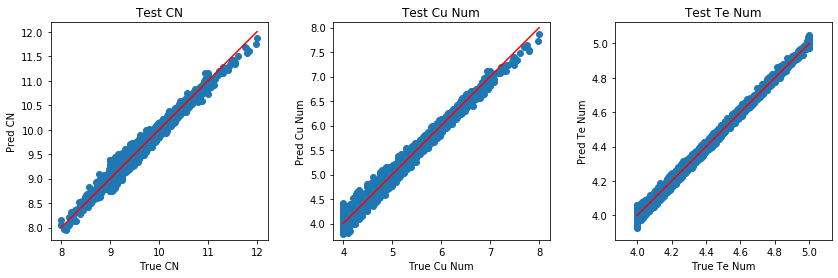

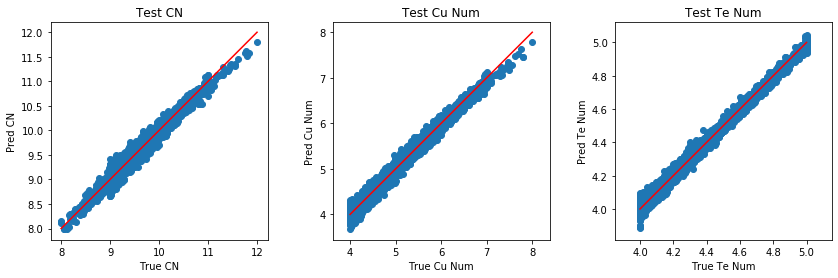

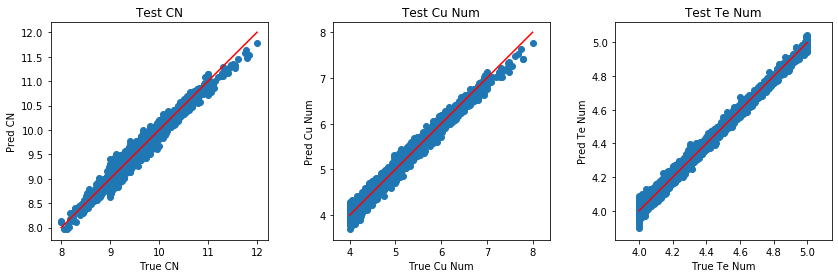

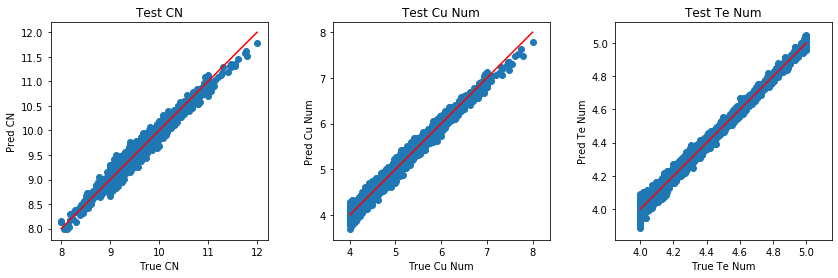

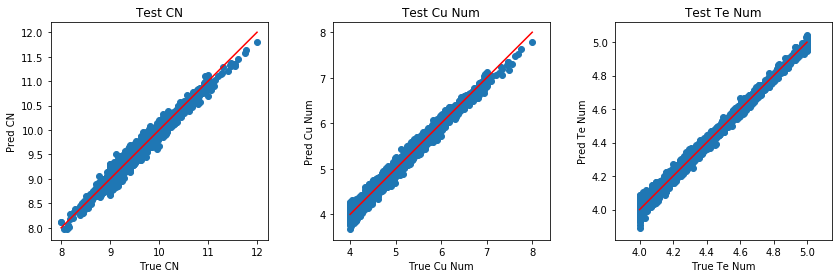

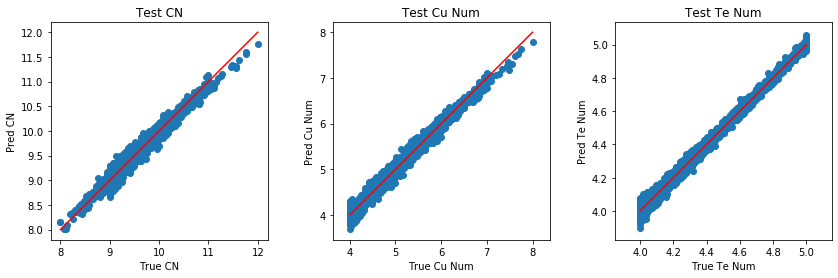

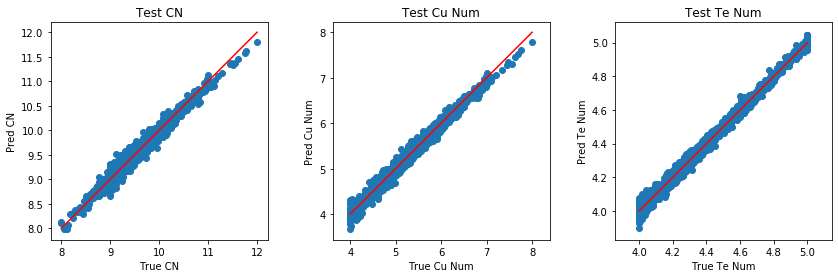

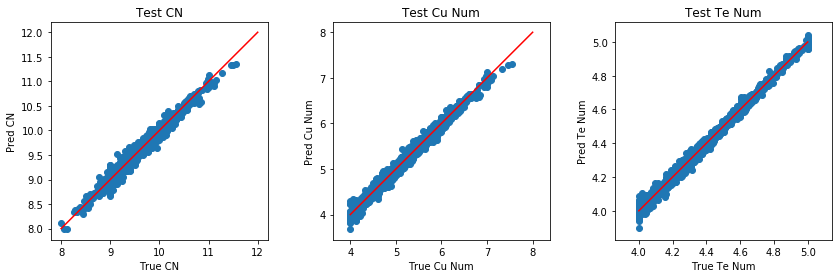

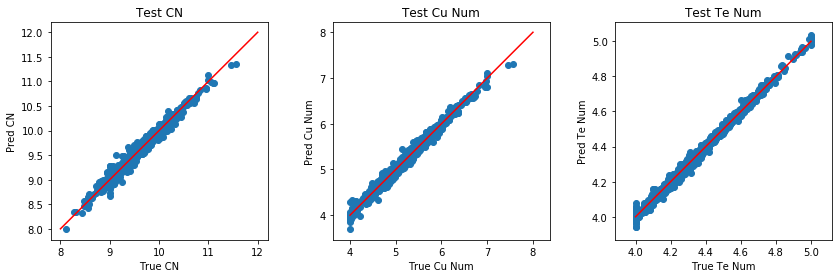

In [7]:
results_df_spectra = average_scores_spectra(iterations, df, size_list)

# Train with first derivative:

In [ ]:
results_df_1 = average_scores_1(iterations, df, Noise_STD)

# Training with second derivative:

In [ ]:
results_df_2 = average_scores_2(iterations, df, Noise_STD)

# Train with both the first and second derivative:

In [ ]:
results_df_1_2 = average_scores_1_2(iterations, df, Noise_STD)

# Plot the error for predicting coordination number:

In [ ]:

plt.rcParams.update({'font.size': 14})
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[12,5])
plt.subplots_adjust(wspace=0.3)
ax1.plot(size_list, results_df_spectra['r2_CN'], c='blue', lw=2.5, label='Spectrum')
ax1.plot(size_list, results_df_1['r2_CN'], c='red', lw=2.5, label='First Derivative')
ax1.plot(size_list, results_df_2['r2_CN'], c='darkorange', lw=2.5, label='Second Derivative')
ax1.plot(size_list, results_df_1_2['r2_CN'], c='green', lw=2.5, label='Both Derivatives')
ax1.set_xlabel('Percent Test', fontsize=16)
ax1.set_ylabel('$R^2$', fontsize=16)
ax2.plot(size_list, results_df_spectra['rmse_CN'], c='blue', lw=2.5)
ax2.plot(size_list, results_df_1['rmse_CN'], c='red', lw=2.5)
ax2.plot(size_list, results_df_2['rmse_CN'], c='darkorange', lw=2.5)
ax2.plot(size_list, results_df_1_2['rmse_CN'], c='green', lw=2.5)
ax2.set_xlabel('Percent Test', fontsize=16)
ax2.set_ylabel('RMSE', fontsize=16)
ax1.legend()
plt.show()

# Plot the error for predicting number of nearest Cu:

In [ ]:
plt.rcParams.update({'font.size': 14})
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[12,5])
plt.subplots_adjust(wspace=0.3)
ax1.plot(size_list, results_df_spectra['r2_Cu'], c='blue', lw=2.5, label='Spectrum')
ax1.plot(size_list, results_df_1['r2_Cu'], c='red', lw=2.5, label='First Derivative')
ax1.plot(size_list, results_df_2['r2_Cu'], c='darkorange', lw=2.5, label='Second Derivative')
ax1.plot(size_list, results_df_1_2['r2_Cu'], c='green', lw=2.5, label='Both Derivatives')
ax1.set_xlabel('Set Size', fontsize=16)
ax1.set_ylabel('$R^2$', fontsize=16)
ax2.plot(size_list, results_df_spectra['rmse_Cu'], c='blue', lw=2.5)
ax2.plot(size_list, results_df_1['rmse_Cu'], c='red', lw=2.5)
ax2.plot(size_list, results_df_2['rmse_Cu'], c='darkorange', lw=2.5)
ax2.plot(size_list, results_df_1_2['rmse_Cu'], c='green', lw=2.5)
ax2.set_xlabel('Set Size', fontsize=16)
ax2.set_ylabel('RMSE', fontsize=16)
ax1.legend()
plt.show()

# Plot the error for predicting number of nearest Te

In [ ]:
plt.rcParams.update({'font.size': 14})
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[12,5])
plt.subplots_adjust(wspace=0.3)
ax1.plot(size_list, results_df_spectra['r2_Te'], c='blue', lw=2.5, label='Spectrum')
ax1.plot(size_list, results_df_1['r2_Te'], c='red', lw=2.5, label='First Derivative')
ax1.plot(size_list, results_df_2['r2_Te'], c='darkorange', lw=2.5, label='Second Derivative')
ax1.plot(size_list, results_df_1_2['r2_Te'], c='green', lw=2.5, label='Both Derivatives')
ax1.set_xlabel('Set Size', fontsize=16)
ax1.set_ylabel('$R^2$', fontsize=16)
ax2.plot(size_list, results_df_spectra['rmse_Te'], c='blue', lw=2.5)
ax2.plot(size_list, results_df_1['rmse_Te'], c='red', lw=2.5)
ax2.plot(size_list, results_df_2['rmse_Te'], c='darkorange', lw=2.5)
ax2.plot(size_list, results_df_1_2['rmse_Te'], c='green', lw=2.5)
ax2.set_xlabel('Set Size', fontsize=16)
ax2.set_ylabel('RMSE', fontsize=16)
ax1.legend()
plt.show()